In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

In [15]:
import os
file_path = os.getcwd()
train_path = os.path.join(file_path, "데이터셋", "train.csv")
test_path = os.path.join(file_path, "데이터셋", "test.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

<Axes: xlabel='대출 상환 기간', ylabel='count'>

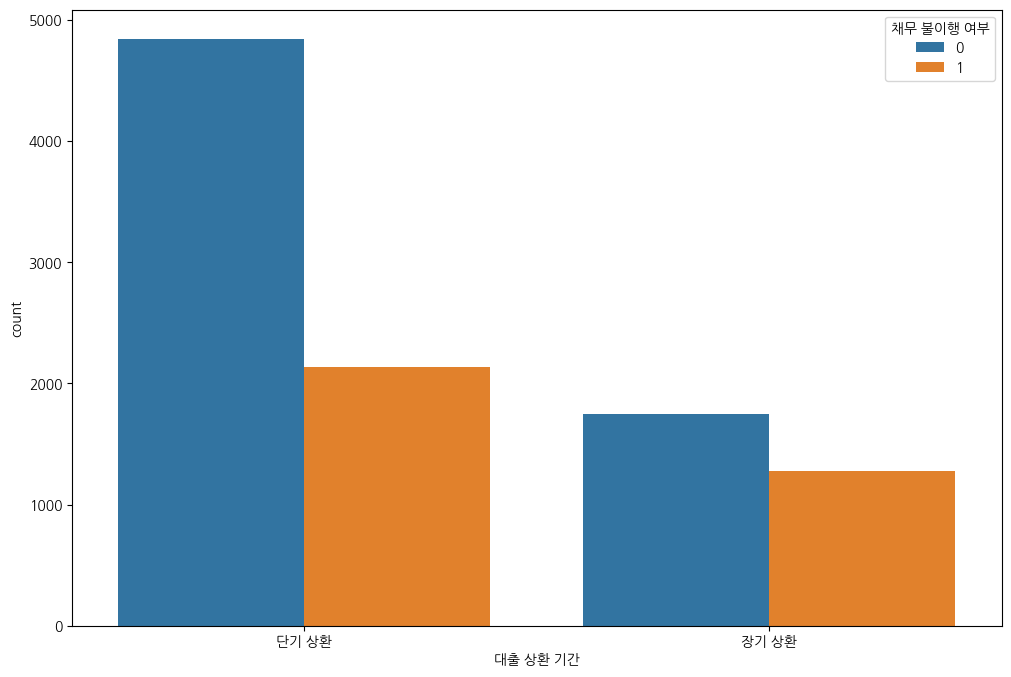

In [16]:
plt.rc("font", family = "NanumGothic")
plt.figure(figsize = (12,8))
sns.countplot(x = "대출 상환 기간", hue = "채무 불이행 여부", data = train_df)

In [ ]:
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))
    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(float)
    
    
    cols = (["주거 형태", "대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)

    

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].where((df["현재 대출 잔액"] > 0), np.nan)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].fillna(df["현재 대출 잔액"].median())
    df["최대 신용한도"] = df["최대 신용한도"].where((df["최대 신용한도"] > 0), np.nan)
    df["최대 신용한도"] = df["최대 신용한도"].fillna(df["최대 신용한도"].median())
    df["대출액+신용액"] = df["현재 대출 잔액"] + df["현재 미상환 신용액"]
    df["상환액 분위"] = pd.qcut(df["대출액+신용액"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["신용점수분위"] = pd.qcut(df["신용 점수"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["대출잔액 분위수"] = pd.qcut(df["현재 대출 잔액"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["직장근속연수 분위수"] = pd.qcut(df["현재 직장 근속 연수"], 7, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["연체 이후 경과 개월 분위수"] = pd.qcut(df["마지막 연체 이후 경과 개월 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)



    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] + df["현재 미상환 신용액"] )  / ((df["최대 신용한도"] * df["개설된 신용계좌 수"]))* 100


    df["DTI"] = ((df["현재 대출 잔액"] + df["현재 미상환 신용액"]) / df["연간 소득"]) * 100
    df["DSR"] = (((df["월 상환 부채액"] + 1)) / (df["연간 소득"]/ 12)) * 100

    df["DTI분위"] = pd.qcut(df["DTI"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["DSR분위"] = pd.qcut(df["DSR"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
 
    


    df["신용위험"] = ((df["개설된_신용계좌_분위수"] >= 3) & (df["신용점수분위"] <= 3) & (df["신용거래분위"] <= 3)).astype(int)
    df["소득위험"] = ((df["직장근속연수 분위수"] < 3) & (df["연간소득분위"] < 3)).astype(int)
    df["대출위험"] = ((df["상환액 분위"] > 3) & (df["DSR분위"] < 3)).astype(int)
    df["파산위험"] = ((df["신용 문제 발생 횟수"] > 0) | ((df["개인 파산 횟수"] > 0) | (df["체납 세금 압류 횟수"] > 0))).astype(int)
    df["부채통합위험"] = ((df["대출 목적"] == 4) & (df["DTI분위"] > 3)).astype(int)
    df["부채통합위험2"] = ((df["대출 목적"] != 4) & (df["파산위험"] == 1)).astype(int)
    df["장기상환위험"] = ((df["대출 상환 기간"] == 1) & (df["신용점수분위"] < 3)).astype(int)
    
    

    df["위험분자"] = df["신용위험"] + df["소득위험"] + df["대출위험"] + df["파산위험"] + df["부채통합위험"] +df["부채통합위험2"] + df["장기상환위험"]


    df["위험분자분위"] = pd.qcut(df["위험분자"], 55, labels = [1,2,3,4,5], duplicates= "drop").astype(int)



    df["근속연수vs거래연수"] = (df["현재 직장 근속 연수"] / df["신용 거래 연수"]) * 100

    df["개설계좌vs연체이후개월수"] = df["개설된 신용계좌 수"] / (df["마지막 연체 이후 경과 개월 수"] + 1) * 100



    df = df.drop(["대출액+신용액", "DSR분위", "DTI분위", "상환액 분위"], axis = 1)
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,신용위험,소득위험,대출위험,파산위험,부채통합위험,부채통합위험2,장기상환위험,위험분자,근속연수vs거래연수,개설계좌vs연체이후개월수
0,TRAIN_00000,1,1941337.5,10,0.0,9,13.4,400597.5,0,24,...,0,0,0,1,0,0,0,1,74.626866,36.000000
1,TRAIN_00001,0,1979505.0,10,0.0,5,15.1,360679.5,0,11,...,0,0,0,0,1,0,0,1,66.225166,41.666667
2,TRAIN_00002,0,1356381.0,4,0.0,12,18.8,491770.5,1,74,...,0,1,0,1,1,0,0,3,21.276596,16.000000
3,TRAIN_00003,0,1049017.5,6,0.0,15,14.8,411546.0,1,22,...,0,0,0,1,1,0,0,2,40.540541,65.217391
4,TRAIN_00004,0,4320217.5,2,0.0,11,26.1,895288.5,0,32,...,0,0,1,0,0,0,0,1,7.662835,33.333333


In [18]:
from scipy.stats import boxcox
from scipy.special import boxcox1p

cols = ["연간 소득", "월 상환 부채액", "현재 대출 잔액", "현재 미상환 신용액", "신용 점수", "DTI", "DSR", "개설된 신용계좌 수", "신용 거래 연수", "신용한도vs대출잔액", "최대 신용한도", "근속연수vs거래연수", "개설계좌vs연체이후개월수"]
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())
    
    train[c], l = boxcox(train[c])
    test[c]= boxcox(test[c], lmbda = l)
print(train[cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   연간 소득          10000 non-null  float64
 1   월 상환 부채액       10000 non-null  float64
 2   현재 대출 잔액       10000 non-null  float64
 3   현재 미상환 신용액     10000 non-null  float64
 4   신용 점수          10000 non-null  float64
 5   DTI            10000 non-null  float64
 6   DSR            10000 non-null  float64
 7   개설된 신용계좌 수     10000 non-null  float64
 8   신용 거래 연수       10000 non-null  float64
 9   신용한도vs대출잔액     10000 non-null  float64
 10  최대 신용한도        10000 non-null  float64
 11  근속연수vs거래연수     10000 non-null  float64
 12  개설계좌vs연체이후개월수  10000 non-null  float64
dtypes: float64(13)
memory usage: 1015.8 KB
None


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


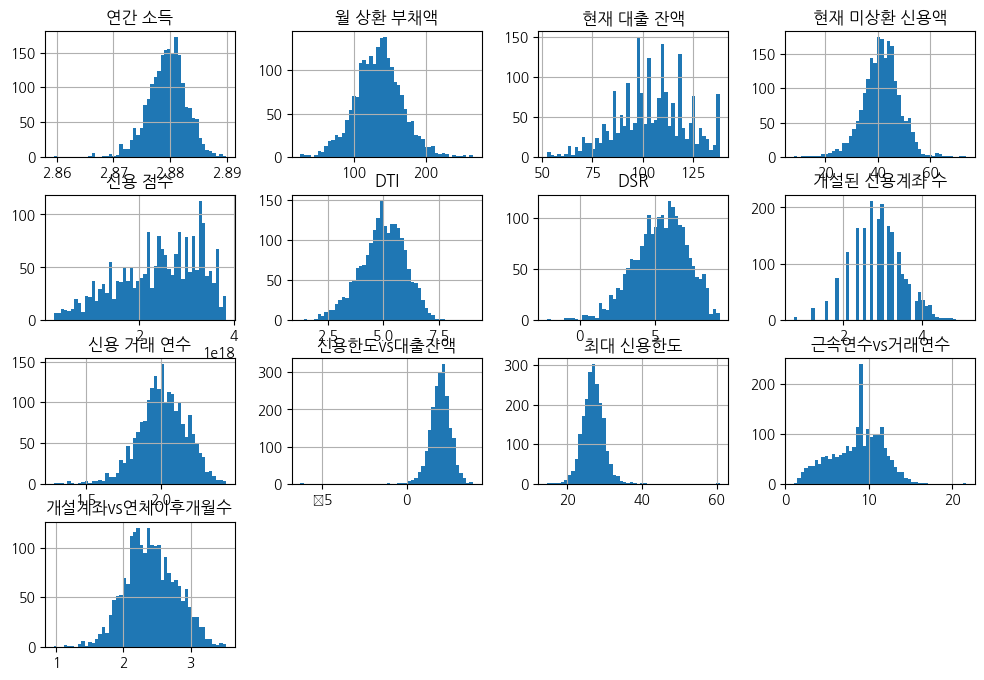

In [19]:
test[cols].hist(figsize = (12,8), bins = 50);

In [20]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

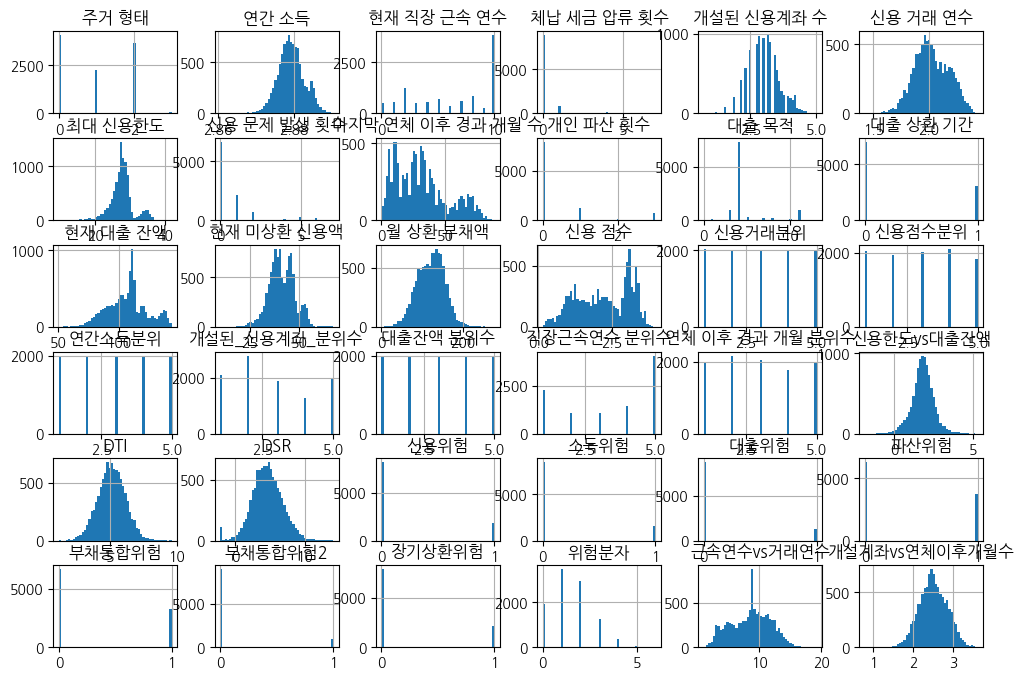

In [21]:
train.hist(figsize = (12,8),bins = 50);

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()


<Axes: >

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  func(*args, **kwargs)
C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


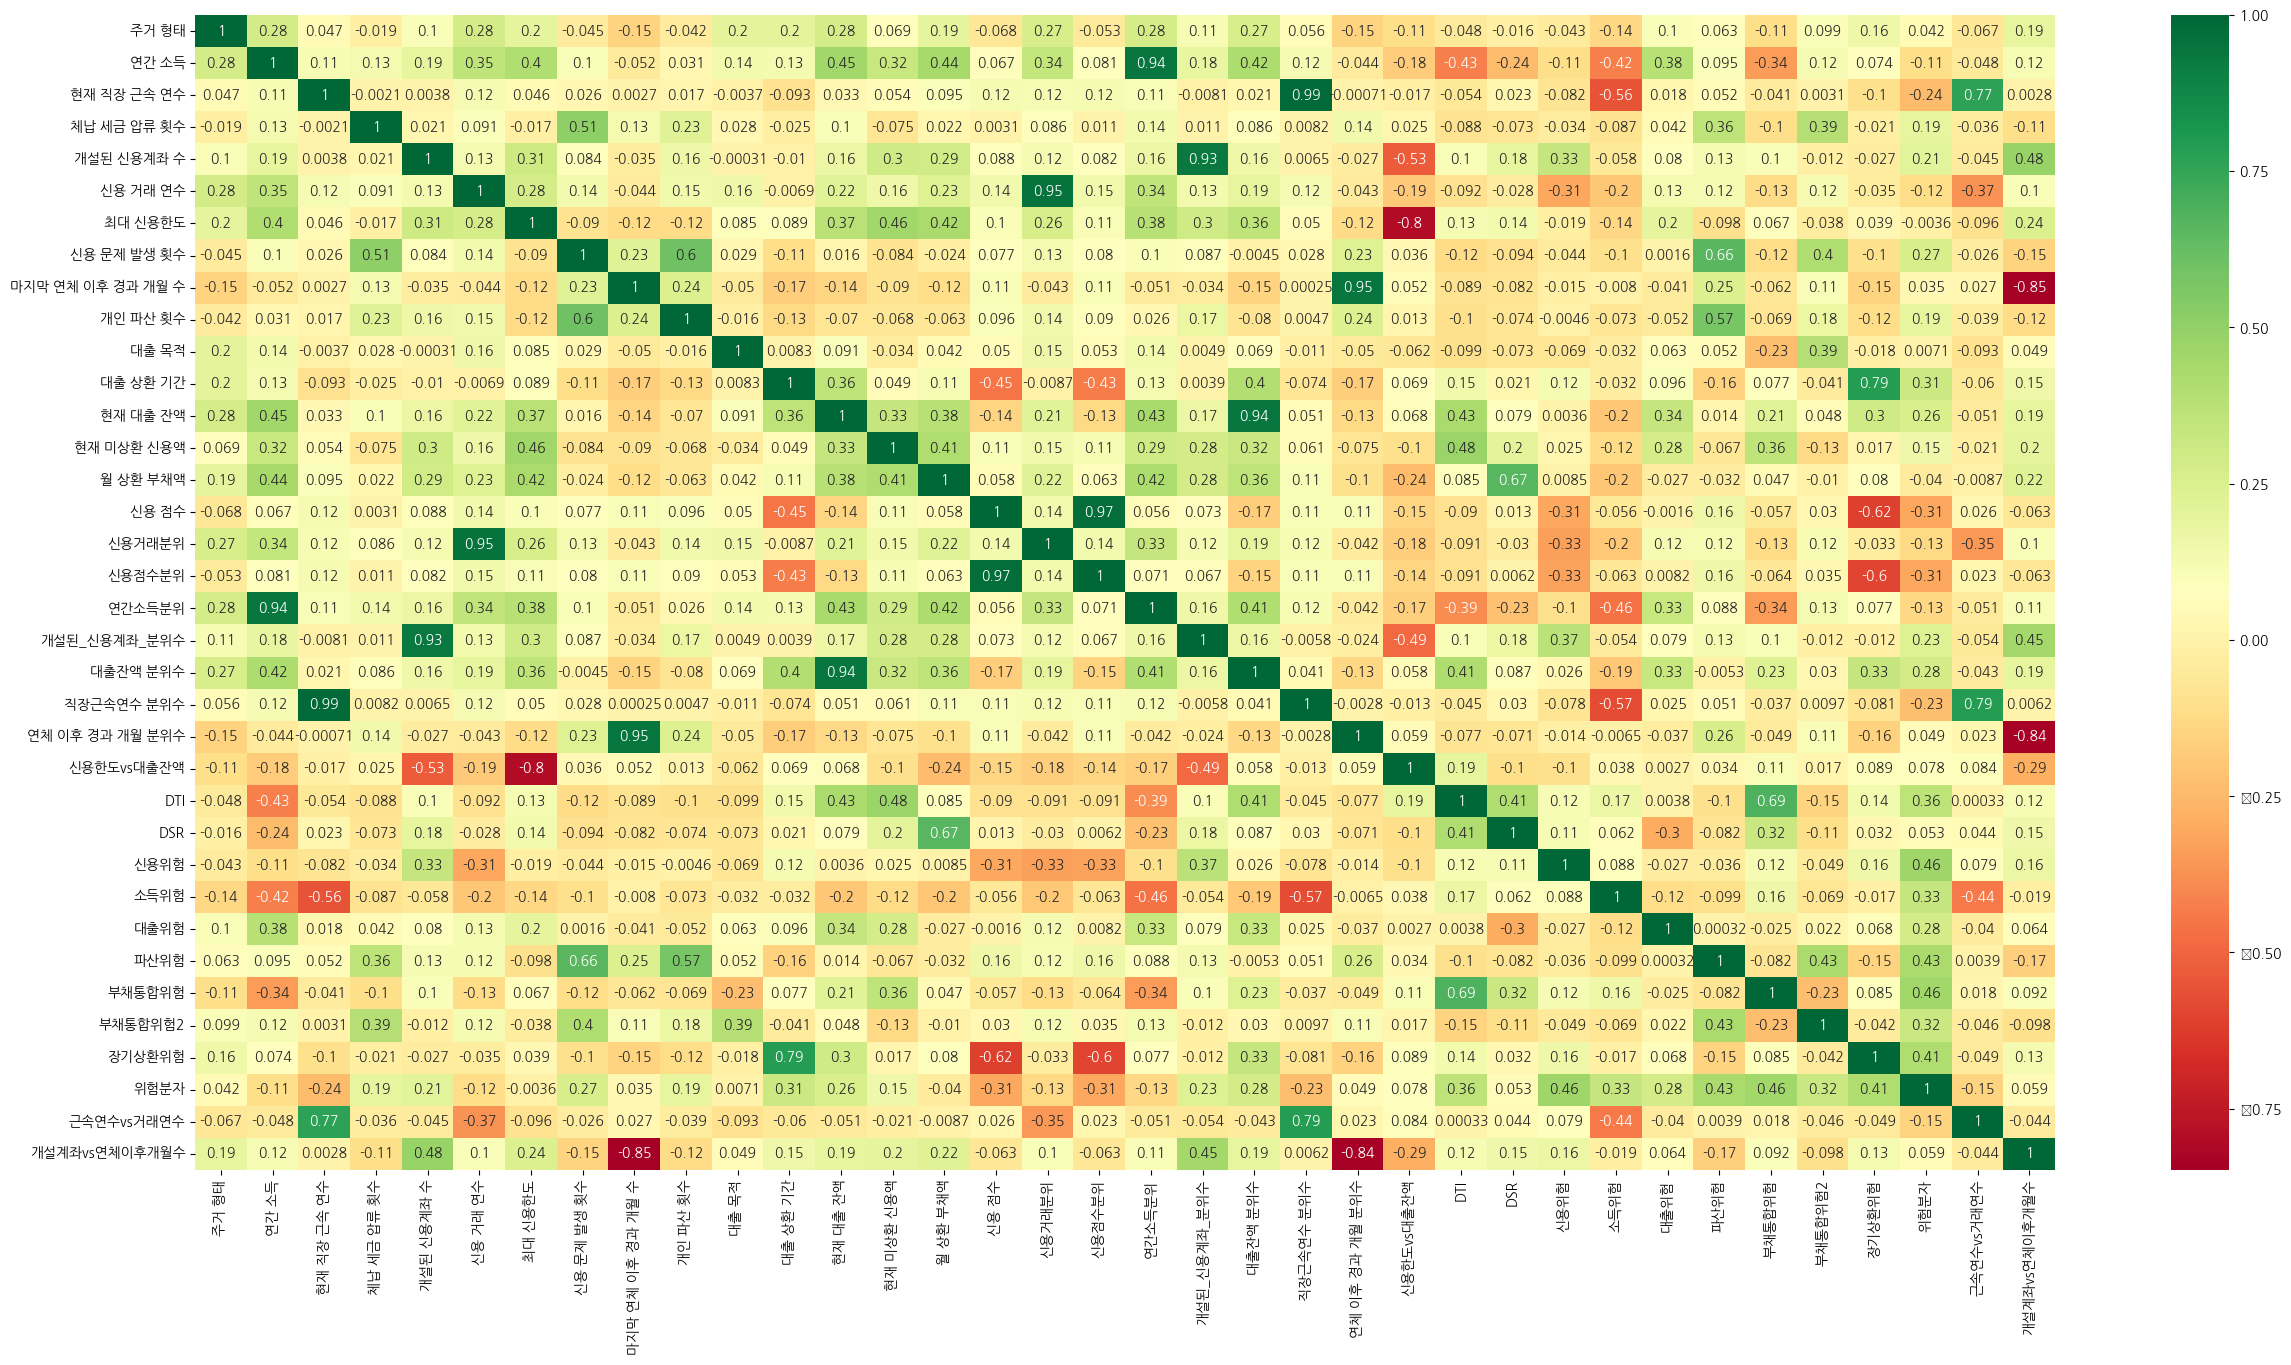

In [22]:
corrmat = train.corr()
corr_cols = corrmat.index[abs(corrmat["위험분자"] >= 0.1)]
plt.figure(figsize = (30,15))
sns.heatmap(train.corr(), annot = True, cmap = "RdYlGn")

In [23]:
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(train)
test_scaled = minmax.transform(test)

In [24]:
smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

Fold 1 시작!
Epoch 1/100


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5101 - loss: 0.6971 - val_accuracy: 0.5592 - val_loss: 0.6876
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5222 - loss: 0.6921 - val_accuracy: 0.5877 - val_loss: 0.6843
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5371 - loss: 0.6881 - val_accuracy: 0.6049 - val_loss: 0.6812
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5402 - loss: 0.6878 - val_accuracy: 0.6201 - val_loss: 0.6783
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5485 - loss: 0.6855 - val_accuracy: 0.6330 - val_loss: 0.6753
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5596 - loss: 0.6815 - val_accuracy: 0.6383 - val_loss: 0.6722
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5529 - loss: 0.6798 - val_accuracy: 0.6431 - val_loss: 0.6693
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5704 - loss: 0.6776 - val_accuracy: 0.6440

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4843 - loss: 0.7067 - val_accuracy: 0.4822 - val_loss: 0.6965
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4924 - loss: 0.7022 - val_accuracy: 0.4856 - val_loss: 0.6935
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4974 - loss: 0.6977 - val_accuracy: 0.5238 - val_loss: 0.6912
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4968 - loss: 0.6976 - val_accuracy: 0.5653 - val_loss: 0.6890
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5189 - loss: 0.6922 - val_accuracy: 0.5776 - val_loss: 0.6869
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5349 - loss: 0.6895 - val_accuracy: 0.5835 - val_loss: 0.6848
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5437 - loss: 0.6881 - val_accuracy: 0.5908 - val_loss: 0.6826
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5595 - loss: 0.6851 - val_accuracy: 0.6017

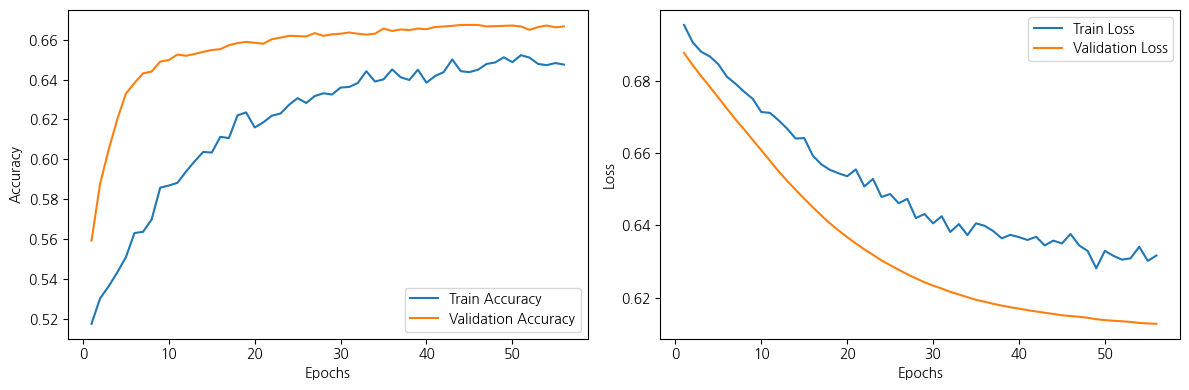

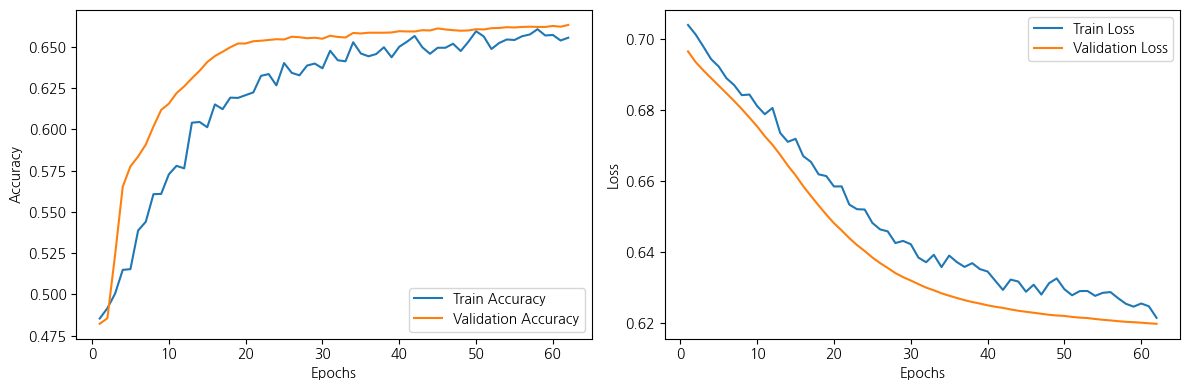

In [25]:
all_history = []
kf = KFold(n_splits = 2, shuffle= True, random_state= 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"Fold {fold} 시작!")
    
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]


    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation = "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(32, activation = "relu"),
        tf.keras.layers.Dense(1, activation= "sigmoid")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        callbacks = earlystop,
        batch_size = 32,
        verbose = 1
    )
    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold{fold} ROC-AUC score {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차 검증 ROC-AUC 평균점수 {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
pred = model.predict(test_scaled).ravel()

sub_path = os.path.join(file_path, "데이터셋", "sample_submission.csv")
submission = pd.read_csv(sub_path)

submission["채무 불이행 확률"] = pred * 100
submission.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission(제출용).csv", index = False) 

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
